## conda environments

When accessing this notebook via the JASMIN Jupyter Notebook service, select the correct conda environment from the list of available kernels.

## Imports

In [8]:
import pandas as pd
from os import path
#from data_classes import LAQNData
import requests
from tqdm import tqdm
import numpy as np
import wandb

## Code

In [26]:
class LAQNData():
    def __init__(self, url, home_folder, species, start_date, end_date):
        self.url = url
        self.home_folder = home_folder
        self.species = species
        self.start_date = start_date
        self.end_date = end_date
        self.filename = f"{self.species}_hourly_{self.start_date}_{self.end_date}.csv"
        self.filepath = path.join(self.home_folder, self.filename)
        
        if not path.exists(self.home_folder):
            makedirs(self.home_folder)
        
        london_sites = requests.get(self.url)
        self.sites_df = pd.DataFrame(london_sites.json()['Sites']['Site'])
        self.site_codes = self.sites_df["@SiteCode"].tolist()

    def download(self, verbose=True):
        laqn_df = pd.DataFrame()
        
        if verbose:
            progress_bar = tqdm(self.site_codes)
        else:
            progress_bar = self.site_codes
            
        for site_code in progress_bar:
            if verbose:
                progress_bar.set_description(f'Working on site {site_code}')
            url_species = f"http://api.erg.kcl.ac.uk/AirQuality/Data/SiteSpecies/SiteCode={site_code}/SpeciesCode={self.species}/StartDate={self.start_date}/EndDate={self.end_date}/csv"
            cur_df = pd.read_csv(url_species)
            cur_df.columns = ["date", site_code]
            cur_df.set_index("date", drop=True, inplace=True)

            try:
                if laqn_df.empty:
                    laqn_df = cur_df.copy()
                else:
                    laqn_df = laqn_df.join(cur_df.copy(), how="outer")

            except ValueError:  # Trying to join with duplicate column names
                rename_dict = {}
                for x in list(set(cur_df.columns).intersection(laqn_df.columns)):
                    rename_dict.update({x: f"{x}_"})
                    print(f"Renamed duplicated column:\n{rename_dict}")
                laqn_df.rename(mapper=rename_dict, axis="columns", inplace=True)
                if laqn_df.empty:
                    laqn_df = cur_df.copy()
                else:
                    laqn_df = laqn_df.join(cur_df.copy(), how="outer")
                if verbose:
                    print(f"Joined.")

            except KeyError:  # Trying to join along indexes that don't match
                print(f"Troubleshooting {site_code}...")
                cur_df.index = cur_df.index + ":00"
                if laqn_df.empty:
                    laqn_df = cur_df.copy()
                else:
                    laqn_df = laqn_df.join(cur_df.copy(), how="outer")
                print(f"{site_code} joined.")

        #print("Data download complete. Removing sites with 0 data...")
        laqn_df.dropna(axis="columns", how="all", inplace=True)
        #laqn_df.to_csv(path.join(self.home_folder, self.filename))
        #print("Data saved.")
        return laqn_df
        
    def download_and_log(self):
        with wandb.init(project="AQmortality", job_type="load-data") as run:
            df = self.download()
            columns = df.columns.to_list()

            raw_data = wandb.Artifact(
                "laqn-raw", type="dataset",
                description=f"Raw LAQN {self.species} data from {self.start_date} to {self.end_date}, split according to site codes.",
                metadata={"source":self.url,
                         "shapes":[df[column].shape for column in columns],
                         "columns":columns})

            for column in columns:
                with raw_data.new_file(column + ".npz", mode="wb") as file:
                        np.savez(file, x=df.index, y=df[column].values)

            run.log_artifact(raw_data)

    def read_csv(self, verbose=True, index_col="date", parse_dates=True):
        if verbose:
            print(f"Reading {self.filename}...")
        return pd.read_csv(self.filepath, index_col=index_col, parse_dates=parse_dates)
    
    def read(self, sites):
        with wandb.init(project="AQmortality", job_type="read-data") as run:
            raw_data_artifact = run.use_artifact('laqn-raw:latest')
            data_folder = raw_data_artifact.download()
            df = pd.DataFrame()
            empty_sites = []
            for site in sites:
                filepath = path.join(data_folder, f"{site}.npz")
                try:
                    data = np.load(filepath, allow_pickle=True)
                except FileNotFoundError:
                    empty_sites.append(site)
                if df.empty:
                    df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[site])
                else:
                    df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[site]))
            empty_sites = ", ".join(empty_sites)
            print(f"No data for site codes: {empty_sites}")
        return df
    
    def resample_time(self, df, key, quantile_step, verbose=True):
        if key == "D":
            keyword = "daily"
        if key == "W":
            keyword = "weekly"

        save_folder = path.join(self.home_folder, keyword)
        if not path.exists(save_folder):
            makedirs(save_folder)

        aggregation = np.round(np.arange(0, 1 + quantile_step, quantile_step), 2).tolist()

        for method in aggregation:
            aggregated_df = df.copy().resample(key).quantile(method)
            method = f"{int(method * 100)}th_quantile"
            aggregated_df.to_csv(path.join(save_folder, f"{self.species}_{keyword}_{method}.csv"), index=True)
            if verbose:
                print(f"Dataframe shape {aggregated_df.shape}")
        if verbose:
            print("Done.")
        
    def resample_time_and_log(self, date_index):
        
        with wandb.init(project="AQmortality", job_type="resample-data") as run:
            raw_data_artifact = run.use_artifact('laqn-raw:latest')
            data_folder = raw_data_artifact.download()
            df = pd.DataFrame()
            for site in sites:
                filepath = path.join(data_folder, f"{site}.npz")
                try:
                    data = np.load(filepath, allow_pickle=True)
                except FileNotFoundError:
                    continue
                if df.empty:
                    df = pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[site])
                else:
                    df = df.join(pd.DataFrame(index=pd.DatetimeIndex(data["x"]), data=data["y"], columns=[site]))

            df = df.loc[df.index < date_index.max()]
            df = df.loc[df.index > date_index.min()]
            resampled_df = df.groupby(date_index[date_index.searchsorted(df.index)]).mean()
            columns = resampled_df.columns.to_list()
            resample_data = wandb.Artifact(
                "laqn-resample", type="dataset",
                description=f"Resampled LAQN {self.species} data from {self.start_date} to {self.end_date}, split according to site codes.",
                metadata={"source":self.url,
                         "shapes":[resampled_df[column].shape for column in columns],
                         "sites":columns},
                        "species":self.species,
                        "start_date":self.start_date,
                        "end_date":self.end_date)
            for column in columns:
                with resample_data.new_file(column + ".npz", mode="wb") as file:
                        np.savez(file, x=df.index, y=resampled_df[column].values)

            run.log_artifact(resample_data)

In [18]:
home_folder = path.join(path.abspath(""), "LAQN_data")
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [27]:
NO2_hourly = LAQNData(url, home_folder, species, start_date, end_date)

In [20]:
print(len(NO2_hourly.site_codes))

236


### Download the LAQN NO$_2$ data

In [13]:
#NO2_hourly.download()
NO2_hourly.download_and_log()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Working on site VS1: 100%|██████████| 236/236 [30:19<00:00,  7.71s/it] 


### Load the NO$_2$ data and aggregate to weekly time steps

In [28]:
#hourly_df = NO2_hourly.read_csv()
hourly_df = NO2_hourly.read(sites=NO2_hourly.site_codes)

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact laqn-raw:latest, 1146.21MB. 192 files... Done. 0:0:0


No data for site codes: BX0, BQ8, BQ6, BQ5, BX9, BQ9, BX6, BX3, BQ3, BQ4, BQ2, BQ1, BY5, BY1, BY4, KX4, CT8, CR8, CR3, EG1, EA0, EI0, EI8, EI7, GB0, HV2, HS3, IS5, IS4, KC7, KF1, KT1, LW3, TD5, ME5, ME6, ME2, AZ99, SK9, SKB, WA1, WA3, BP0, MY7


Now we choose a temporal resolution (key) and size of quantile steps to aggregate the data over.
For example, `key="W", quantile_step=0.25` produces 4 .csv files, each containing a 25th percentile of the data distribution at weekly scale. Spatial resolution is retained i.e. still contains data for all sites.

In [141]:
NO2_hourly.resample_time(hourly_df, "W", 0.25)

Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Dataframe shape (1097, 192)
Done.


### Load the median weekly NO$_2$ data and plot

In [6]:
median_filepath = path.join(NO2_hourly.home_folder, "weekly/NO2_weekly_50th_quantile.csv")
median_df = pd.read_csv(median_filepath, index_col="date", parse_dates=True)

In [7]:
median_df.head()

,TD0,BG3,BG1,BG2,BN2,BN3,BN1,BX5,BX2,BQ7,...,WMD,WM0,MY1,WM6,WMZ,WMB,NB1,WM8,WM9,VS1
date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,21.2,NaN,NaN,NaN,NaN,NaN,38.65,24.55,27.30,NaN,...,NaN,NaN,81.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-09,20.6,NaN,NaN,NaN,NaN,NaN,64.10,27.40,28.55,NaN,...,NaN,NaN,93.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-16,40.5,NaN,NaN,NaN,NaN,NaN,60.35,30.50,33.65,NaN,...,NaN,NaN,72.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-23,52.6,NaN,NaN,NaN,NaN,NaN,50.05,46.15,53.00,NaN,...,NaN,NaN,68.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-30,47.6,NaN,NaN,NaN,NaN,NaN,90.15,48.30,56.10,NaN,...,NaN,NaN,98.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

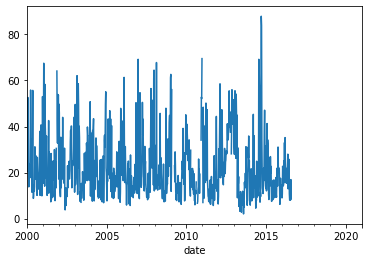

In [150]:
median_df["TD0"].plot()

### Spatially average all the London sites

In [151]:
median_filepath = path.join(NO2_hourly.home_folder, "weekly/NO2_weekly_50th_quantile.csv")
median_df = pd.read_csv(median_filepath, index_col="date", parse_dates=True)
median_df.shape

(1097, 192)

In [161]:
london_df = pd.DataFrame(median_df.mean(axis=1))
london_df.shape

(1097, 1)

In [166]:
london_df.columns=["NO2_site_mean"] # rename this to something more intuitive
london_df.head()

,NO2_site_mean
date,
2000-01-02,48.048182
2000-01-09,52.449138
2000-01-16,53.538983
2000-01-23,57.850847
2000-01-30,63.158772


<AxesSubplot:xlabel='date'>

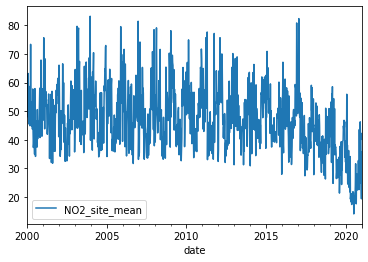

In [165]:
london_df.plot()